### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

### Time series generation

#### Chaotic Dataset

In [3]:
# Skew tent map
def skew_tent_map(n=2**15, omega=0.1847, x0=.5):
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, len(x)):
        if x[i-1] < omega:
            x[i] = x[i-1]/omega
        else:
            x[i] = (1-x[i-1])/(1-omega)
    return x

In [4]:
# Logistic map
def logistic_map(n=2**15, r=4, x0=.4):
    x = np.zeros(n)
    x[0] = x0
    for i in range(n-1):
        x[i+1] = r*x[i]*(1-x[i])
    return x

In [5]:
# Schuster's map
def schuster_map(n=2**15, z=2, x0=.5):
    z = float(z)
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, n):
        x[i], _ = np.modf(x[i-1] + x[i-1]**z)
    return x

In [31]:
# Henon map
def henon_map(n=1000000, a=1.4, b=0.3, x0=0.2 ,y0=0.1):
    x = np.zeros(n)
    y = np.zeros(n)
    x[0] = x0
    y[0] = y0
    for i in range(1, len(x)):
        x[i] = 1 - a * x[i-1] ** 2 + y[i-1]
        y[i] = b * x[i-1]
    return x

#### Sine Dataset (Deterministic)

In [6]:
sine_data = np.sin(np.arange(0,1000,.01))

#### Gaussian Noise (Stochastic)

In [7]:
gaussian_noise = np.random.normal(size=100000)

#### Lorenz

In [11]:
file_path = 'lorenz.txt'

# Read data from the file into a NumPy array
with open(file_path, 'r') as file:
    # Use numpy to convert the lines into a 1D array of floats
    lorenz = np.array([float(line.strip()) for line in file.readlines()])

# Print the resulting NumPy array
print(lorenz)

[0.53696553 0.57039027 0.68672766 ... 0.6160236  0.71350847 0.86349486]


### Main functions

In [12]:
def coompute_coordinates_for_ts(time_series, chunk_len=6, Q0=None):
  """
  C[P] = Qj[P, Pe] * Hs[P] - complexity
  P - distribution of ts (length N), Pe uniform distr (length N)
  Hs[P] - entropy measuer [0,1]
  Qj[P, Pe] - Jonson Shanon divergence
  """
  P = distribution_from_ts(time_series, chunk_len)
  Hs = compute_norm_entropy(P)
  compl = compute_complexity(P, Q0)
  return Hs, compl

In [13]:
def compute_complexity(P, Q0=None):
  """
  C[P] = Qj[P, Pe] * Hs[P]
  P - distribution of ts (length N), Pe uniform distr (length N)
  Hs[P] - entropy measuer [0,1]
  Qj[P, Pe] - Jonson Shanon divergence
  """
  Hs = compute_norm_entropy(P)
  Qj = compute_jonson_shanon_divergence(P, Q0)
  complexity = Qj * Hs
  return complexity

In [14]:
def compute_norm_entropy(P):
    """
    Hs[P] = S[P]/Smax , where Smax -> S[Pe]=ln(N)
    S - shannon entropy
    P - prob_distribution
    Pe - prob_uniform_distribution
    """
    Hs = compute_shannon_entropy(P) / np.log(P.shape[0])
    return Hs

In [15]:
def compute_shannon_entropy(P):
    """
    S[P] = sum_0toN(-pj * ln(pj))
    P - prob_distribution
    """
    P_not0= P[P!=0]
    entropy = np.sum(P_not0 * np.log(P_not0))
    return - entropy

In [16]:
def compute_jonson_shanon_divergence(P, Pe, Q0=None):
    """
    Qj[P, Pe] = Q0{S[(P+Pe)/2] - S[P]/2 - S[Pe]}/2
    S - shannon entropy
    Q0 -normalisation constant [0,1]
    Qj -disiquilibrium [0,1]
    P - prob_distribution
    Pe - prob_uniform_distribution
    """
    if Q0 is None:
        N = P.shape[0]
        Q0 = -2 /(((N+1)/N)*np.log(N+1) - 2*np.log(2*N) + np.log(N) )

    Pe = np.ones(P.shape[0]) * 1/P.shape[0]
    Qj = Q0 * (compute_shannon_entropy((P + Pe)*0.5) - 0.5*compute_shannon_entropy(P) - 0.5*compute_shannon_entropy(Pe))
    return Qj

In [17]:
import math
import itertools
def distribution_from_ts(time_series, chunk_len=6):
    """
    Time series (len m) divide to chunks (len ch).
    Amount of chuncks is m-ch+1
    [[x0,..,xch],[x1,..,xch+1],..,[xm-ch,..,xm-1]]
    Create all posible permutations (amount is chunks_len!) of length chunks (binary [0,0,1,0,0], or digital [1,2,5,4,3])
    Compute frequensy for this pattern in TS patern_freq[10, 4, 0, 2, 4, 0,...].
    And convert it to probability distribution
    """
    chunks = split_into_chunks(time_series)
    # convert to pattern view
    chunks = np.argsort(chunks)
    # count pattern frequency
    patterns , patterns_count = np.unique(chunks, axis=0, return_counts=True)
    # create dict for save counts
    permutations_dict = {prm: 0 for prm in itertools.permutations(range(0, chunk_len-1))}
    # save our frequency to dict
    for pattern, count in zip(patterns, patterns_count):
        permutations_dict[tuple(pattern)] = count
    # take freq array
    freq_array = np.array(list(permutations_dict.values()))
    P = freq_array/freq_array.sum()
    #assert P.sum()==1
    #assert len(permutations_dict) == math.factorial(chunk_len)
    return P

In [18]:
def split_into_chunks(time_series, chunk_len=5, shift=1):
    """
    Time series (len m) divide to chunks (len ch).
    Amount of chuncks is m-ch+1
    [[x0,..,xch],[x1,..,xch+1],..,[xm-ch,..,xm-1]]
    """
    chunks = []
    for i in range(0, len(time_series) - chunk_len + 1, shift):
        chunks.append(time_series[i:i + chunk_len])
    assert len(chunks)== time_series.shape[0] - chunk_len + 1
    #assert time_series[0]==chunks[0][0] and time_series[-1]==chunks[-1][-1] and time_series[chunk_len]==chunks[0][-1]
    return np.array(chunks)

### Count bounders lines

In [19]:
def upper_bound_coordinates(d=6, n_steps=500, Q0=None):
    """
    For min bound:
    # Create a distribution where one state has probability pk and the rest have equal probability for the remaining 1-pk
    # Generate a range of probability values
    probability_range = np.linspace(1 / total_states, 1, num_points)
    For max bound:
    probability_range = np.linspace(0, 1 / total_states, num_points)
    """
    N = math.factorial(d)
    step = (1 - 1/N) / n_steps

    x_coordinates = [] # entropy
    y_coordinates = [] # complexity

    for n in range(N - 1):
        p_max = list(np.arange(0, 1 / (N-n), step))

        for m in range(len(p_max)):
            P_maximize = list()
            P_maximize.append(p_max[m])
            p_rest = (1 - p_max[m]) / (N-n-1)

            for i in range(N-n-1):
                P_maximize.append(p_rest)
            if len(P_maximize) != N:
                P_maximize = np.pad(P_maximize, (0, n), mode='constant')

            P_maximize = np.array(P_maximize)
            x_coordinates.append(compute_norm_entropy(P_maximize))
            y_coordinates.append(compute_complexity(P_maximize, Q0=Q0))

    return np.array(x_coordinates), np.array(y_coordinates)

In [20]:
def lower_bound_coordinates(d=6, n_steps=100, Q0=None):
    """
    For min bound:
    # Create a distribution where one state has probability pk and the rest have equal probability for the remaining 1-pk
    # Generate a range of probability values
    probability_range = np.linspace(1 / total_states, 1, num_points)
    """
    N = math.factorial(d)
    step = (1 - 1/N) / n_steps

    x_coordinates = [] # entropy
    y_coordinates = [] # complexity

    p_min = list(np.arange(1/N, 1, step))

    for n in range(len(p_min)):
        P_minimize = []

        if p_min[n] > 1:
            p_min[n] = 1

        P_minimize.append(p_min[n])

        for i in range(N - 1):
            p_rest = (1 - p_min[n]) / (N-1)
            P_minimize.append(p_rest)

        P_minimize = np.array(P_minimize)
        x_coordinates.append(compute_norm_entropy(P_minimize))
        y_coordinates.append(compute_complexity(P_minimize, Q0=Q0))

    return np.array(x_coordinates), np.array(y_coordinates)

### Draw entropy-complexity plane

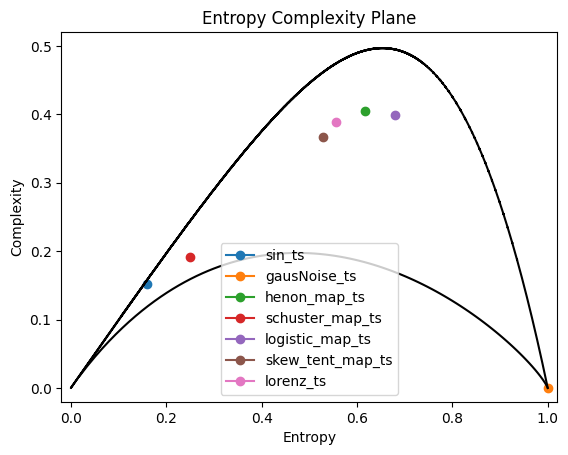

In [32]:
import matplotlib.pyplot as plt

ts_list = [(sine_data, 'sin_ts'),
           (gaussian_noise, 'gausNoise_ts'),
           (henon_map(), 'henon_map_ts'),
           (schuster_map(), 'schuster_map_ts'),
           (logistic_map(), 'logistic_map_ts'),
           (skew_tent_map(), 'skew_tent_map_ts'),
           (lorenz, 'lorenz_ts')]

for ts, name in ts_list:
  x, y = coompute_coordinates_for_ts(ts, chunk_len=6, Q0=1)
  plt.plot(x, y, marker='o', label=name)

x_lb, y_lb = lower_bound_coordinates()
x_ub, y_ub = upper_bound_coordinates()
plt.plot(x_lb, y_lb, 'k')
plt.plot(x_ub, y_ub, 'k')

# Add title and labels
plt.title('Entropy Complexity Plane')
plt.xlabel('Entropy')
plt.ylabel('Complexity')

plt.xlim(-0.02, 1.02)  # Adjust the x-axis limits from 0 to 4
plt.ylim(-0.02, 0.52)

# Add legend
plt.legend()

# Display the plot
plt.show()